# IAPR PROJECT 2024


**Group ID:** 29

**Kaggle Team name:** Group 29

**Author 1 (sciper):** Paul Richard (325336)  
**Author 2 (sciper):** Kenji Tetard (301569)   
**Author 3 (sciper):** Marianne Civit Ardevol (325056)   

**Due date:** 29.05.2024 

This report outlines our approach to solving the challenge of detecting coins on varied backgrounds. We detail the steps involved in our image processing workflow, from initial background recognition to the final output of coin classification. Each phase is designed to enhance the accuracy and efficiency of coin detection across different environments.

1. Background recognation
2. Image pre-processing
    - Coin Finding
    - Sub image creation
3. Coin classification
4. Output format

#### Needed folders for this notebook:

```code
├── Project_group29.ipynb
├── Report-IMG
├── train
├── test
├── requirements.txt
├── model28_05.pth (can also be generated with this notebook)
├── final_train_data_split (can also be generated with this notebook)
├── predicted_coins28_05.csv (can also be generated with this notebook)
```

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python

# **Package importation**


In [1]:
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

# Import main packages
from skimage.morphology import *
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Callable
from PIL import Image
import numpy as np
import matplotlib
import cv2 as cv
import math
import os
import torch
from PIL import Image
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
import csv
import os
import random
import shutil
from datasets import load_dataset
import torchvision


/Users/mariannecivitardevol/miniconda3/envs/iapr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


References:
https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

# **Background detection using thresholding**

In this section, we present all the functions used for displaying results or obtaining data that can assist in analyzing the processing steps.

In [18]:
def display_img(img, title="Image"):
    """ Display an image, either grayscale or color """
    plt.figure(figsize=(6, 6))
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [19]:
def draw_roi_red_square(image_path):
    """
    Draws a red square around the region of interest (ROI) at the bottom middle of an image.

    Parameters:
    - image_path (str): The file path to the input image.

    Returns:
    - img (numpy.ndarray): The image with the ROI highlighted by a red square.
    """

    # Read the image from the given path
    img = cv.imread(image_path)
    
    # Get the dimensions of the image
    height, width, _ = img.shape
    
    # Define the height and width of the ROI (10% of height and 20% of width)
    roi_height = int(height * 0.1)  
    roi_width = int(width * 0.2)    
    
    # Calculate the coordinates of the ROI
    start_y = height - roi_height  
    start_x = (width - roi_width) // 2  
    end_y = height  
    end_x = start_x + roi_width  
    
    # Draw a red rectangle around the ROI
    cv.rectangle(img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 14)
    
    return img

# **Background detection using thresholding**


## Method explanation

The initial phase of our algorithm involves detecting the background, which is a crucial step for subsequent background removal. Given that we deal with only three distinct background types—neutral (white), hand, and noisy—our approach for identifying each scenario is straightforward. We employ a thresholding method focused on specific parts of the image, typically the lower border. This area is particularly useful for determining the nature of the background due to its uniformity and relevance across our image set.

The detection process involves several key steps:

**Extracting the Region of Interest (ROI):**

- We define the ROI as a small section at the bottom middle of the image. This region is selected because it consistently contains representative background information.

**Calculating Mean RGB and HSV Values:**

- For the selected ROI, we compute the mean values for both RGB and HSV color spaces. This dual approach allows us to leverage different color space characteristics for more robust background identification.

**Threshold-Based Classification:**

- Using predefined threshold values, we classify the background into one of the three categories:
  - **Neutral Background:** Identified by low hue and saturation values.
  - **Noisy Background:** Characterized by specific thresholds in RGB and HSV mean values, indicating the presence of noise.
  - **Hand Background:** Determined by RGB and HSV values that deviate from those of neutral and noisy backgrounds, typically indicating the presence of a hand.

The thresholding approach is both simple and effective for our use case, ensuring accurate background identification, which is crucial for the subsequent steps in our image processing pipeline. The three scenarios are illustrated below:

<img src="Report-IMG/Neutral_Background.png" alt="Neutral Background" style="width: 33%;"/>
<img src="Report-IMG/Hand_Background.png" alt="Hand Background" style="width: 33%;"/>
<img src="Report-IMG/Noisy_Backgournd.png" alt="Noisy Background" style="width: 33%;"/>


We have used the following functions to calculate the mean in therms of BGR and HSV of this region to find the best thresholds:

In [21]:
def get_image_rgb_means(img, hsv=False):
    """
    Calculates the mean values of the RGB (or HSV) channels for an image.

    Parameters:
    - img (numpy.ndarray): The input image.
    - hsv (bool): If True, converts the image to HSV color space before calculating means. Default is False.

    Returns:
    - list: A list containing the mean values of the Blue, Green, and Red channels (or Hue, Saturation, and Value if hsv is True).
    """
    
    # Convert image to HSV color space if specified
    if hsv:
        img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    # Calculate the mean values for each channel
    img_blue = img[:, :, 0].mean()
    img_green = img[:, :, 1].mean()
    img_red = img[:, :, 2].mean()
    
    # Return the mean values as a list
    return [img_blue, img_green, img_red]


def get_image_rgb_means_border(img, hsv=False):
    """
    Calculates the mean values of the RGB (or HSV) channels for the region of interest (ROI)
    at the bottom middle of an image.

    Parameters:
    - img (numpy.ndarray): The input image.
    - hsv (bool): If True, converts the ROI to HSV color space before calculating means. Default is False.

    Returns:
    - list: A list containing the mean values of the Blue, Green, and Red channels (or Hue, Saturation, and Value if hsv is True) for the ROI.
    """
    
    # Get the dimensions of the image
    height, width, _ = img.shape
    
    # Define the height and width of the ROI
    roi_height = int(height * 0.1)
    roi_width = int(width * 0.2)
    
    # Calculate the coordinates of the ROI
    start_y = height - roi_height
    start_x = (width - roi_width) // 2
    end_y = height
    end_x = start_x + roi_width
    
    # Extract the ROI from the image
    roi = img[start_y:end_y, start_x:end_x]
    
    # Convert the ROI to HSV color space if specified
    if hsv:
        roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    
    # Calculate the mean values for each channel in the ROI
    img_blue = roi[:, :, 0].mean()
    img_green = roi[:, :, 1].mean()
    img_red = roi[:, :, 2].mean()

    # Return the mean values as a list
    return [img_blue, img_green, img_red]


def get_back_ground_type_mean_rgb(folders, hsv=False):
    """
    Computes the mean RGB (or HSV) values for images in the specified folders. Each folder containing images of specific background

    Parameters:
    - folders (list of str): List of folder paths containing images.
    - hsv (bool): If True, converts the images to HSV color space before calculating means. Default is False.

    Returns:
    - np.ndarray: Array of mean values for each image in the folders.
    """
    
    list_mean_rgb = []

    # Iterate over each folder path in the list
    for folder_path in folders:
        
        # Iterate over each file in the current folder
        for filename in os.listdir(folder_path):
            
            # Process only JPG files
            if filename.endswith(".JPG"):  
                img_path = os.path.join(folder_path, filename)
                img = cv.imread(img_path)
                means = get_image_rgb_means_border(img, hsv)
                list_mean_rgb.append(means)

    return np.array(list_mean_rgb)


def get_array_rgb_mean_var(background_type, folders, hsv):
    """
    Calculates and prints the mean and variance of RGB (or HSV) values for a given background type.

    Parameters:
    - background_type (str): Type of the background (e.g., 'neutral', 'noisy', 'hand').
    - folders (list of str): List of folder paths containing images.
    - hsv (bool): If True, calculates the mean and variance for HSV values. Default is False.
    """
    
    mean_rgb_array = get_back_ground_type_mean_rgb(folders, hsv)
    
    if hsv:
        # Calculate the mean of each HSV channel
        mean_h = np.mean(mean_rgb_array[:, 0])
        mean_s = np.mean(mean_rgb_array[:, 1])
        mean_v = np.mean(mean_rgb_array[:, 2])

        # Calculate the variance of each HSV channel
        variance_h = np.var(mean_rgb_array[:, 0])
        variance_s = np.var(mean_rgb_array[:, 1])
        variance_v = np.var(mean_rgb_array[:, 2])

        hsv_text = "HSV"
        print(f"--------{background_type} mean and var hsv values {hsv_text}--------")
        print("Mean HSV Values:")
        print(f"Mean Hue: {mean_h:.2f}, Mean Saturation: {mean_s:.2f}, Mean Value: {mean_v:.2f}")

        print("\nVariance in HSV Values:")
        print(f"Variance Hue: {variance_h:.2f}, Variance Saturation: {variance_s:.2f}, Variance Value: {variance_v:.2f}\n{'-'*60}\n\n")
    else:
        # Calculate the mean of each RGB channel
        mean_r = np.mean(mean_rgb_array[:, 2])
        mean_g = np.mean(mean_rgb_array[:, 1])
        mean_b = np.mean(mean_rgb_array[:, 0])

        # Calculate the variance of each RGB channel
        variance_r = np.var(mean_rgb_array[:, 2])
        variance_g = np.var(mean_rgb_array[:, 1])
        variance_b = np.var(mean_rgb_array[:, 0])

        hsv_text = ""
        print(f"--------{background_type} mean and var rgb values {hsv_text}--------")
        print("Mean RGB Values:")
        print(f"Mean Red: {mean_r:.2f}, Mean Green: {mean_g:.2f}, Mean Blue: {mean_b:.2f}")

        print("\nVariance in RGB Values:")
        print(f"Variance Red: {variance_r:.2f}, Variance Green: {variance_g:.2f}, Variance Blue: {variance_b:.2f}\n{'-'*60}\n\n")

# Define the folders for each background type
folders = {
        'neutral': ['train/1. neutral_bg', 'train/4. neutral_bg_outliers'],
        'noisy': ['train/2. noisy_bg', 'train/5. noisy_bg_outliers'],
        'hand': ['train/3. hand', 'train/6. hand_outliers']
}

# Run the analysis for each background type
for background_type, folder_paths in folders.items():
    get_array_rgb_mean_var(background_type, folder_paths, hsv=False)
    get_array_rgb_mean_var(background_type, folder_paths, hsv=True)



--------neutral mean and var rgb values --------
Mean RGB Values:
Mean Red: 197.44, Mean Green: 190.99, Mean Blue: 184.31

Variance in RGB Values:
Variance Red: 68.13, Variance Green: 85.07, Variance Blue: 103.27
------------------------------------------------------------


--------neutral mean and var hsv values HSV--------
Mean HSV Values:
Mean Hue: 15.10, Mean Saturation: 17.08, Mean Value: 197.44

Variance in HSV Values:
Variance Hue: 0.20, Variance Saturation: 12.60, Variance Value: 68.13
------------------------------------------------------------


--------noisy mean and var rgb values --------
Mean RGB Values:
Mean Red: 173.87, Mean Green: 179.39, Mean Blue: 176.23

Variance in RGB Values:
Variance Red: 36.33, Variance Green: 8.63, Variance Blue: 51.27
------------------------------------------------------------


--------noisy mean and var hsv values HSV--------
Mean HSV Values:
Mean Hue: 67.85, Mean Saturation: 23.79, Mean Value: 184.55

Variance in HSV Values:
Variance Hue:

### Thresholding for Background Classification

In the algorithm, thresholding is utilized to classify the image background based on specific color metrics. This method relies on calculating the mean values of certain color channels within a defined region of interest (ROI) and then applying predefined thresholds to categorize the background into one of three types: neutral, noisy, or hand.

**Classification Criteria:**

- **Neutral Background:**
  - **Hue:** Mean hue value is less than 17.
  - **Saturation:** Mean saturation value is less than 60.
  - **Interpretation:** These thresholds typically indicate a white or uniformly colored background.

- **Noisy Background:**
  - **Red:** Mean red value is less than 185.
  - **Blue:** Mean blue value is less than 192.
  - **Green:** Mean green value exceeds 168.
  - **Saturation:** Mean saturation value is under 53.
  - **Hue:** Mean hue value is below 100.
  - **Interpretation:** These thresholds suggest a varied and cluttered background, indicative of noise.

- **Hand Background:**
  - **Any other scenario:** When the above conditions are not met, the background is classified as containing a hand.
  - **Interpretation:** This category captures images where the color metrics do not fit the profiles of neutral or noisy backgrounds, typically indicating the presence of a hand.

This thresholding approach is straightforward yet highly effective, achieving 100% accuracy on the training set. By leveraging specific color metrics and simple thresholds, the algorithm ensures precise background classification, which is crucial for the subsequent steps in the image processing pipeline.

In [22]:
def classify_background(img):
    """
    Classifies the background of an image based on RGB and HSV mean values of a region of interest (ROI).

    Parameters:
    - img (numpy.ndarray): The input image.

    Returns:
    - str: The predicted background label ('neutral', 'noisy', or 'hand').
    """
    
    # Get RGB and HSV mean values from the ROI
    rgb_means = get_image_rgb_means_border(img, hsv=False)
    hsv_means = get_image_rgb_means_border(img, hsv=True)

    red_mean, green_mean, blue_mean = rgb_means[2], rgb_means[1], rgb_means[0]
    hue_mean, saturation_mean, value_mean = hsv_means[0], hsv_means[1], hsv_means[2]

    # Classify based on threshold values
    if (hue_mean < 17 and saturation_mean < 60):
        return "neutral"
    elif (red_mean < 185 and blue_mean < 192 and green_mean > 168 and saturation_mean < 53 and hue_mean < 100):
        return "noisy"
    else:
        return "hand"
    

def evaluate_classifier():
    """
    Evaluates the classifier on a dataset and prints the accuracy for each background type and overall accuracy.
    Also prints misclassified elements with their RGB and HSV means.
    """

    folders = {
            'neutral': ['train/1. neutral_bg', 'train/4. neutral_bg_outliers'],
            'noisy': ['train/2. noisy_bg', 'train/5. noisy_bg_outliers'],
            'hand': ['train/3. hand', 'train/6. hand_outliers']
    }

    correct_predictions = 0
    total_images = 0

    # Iterate through each label and its corresponding folder paths
    for label, folder_paths in folders.items():
        correct_label_prediction = 0
        label_image = 0

        # Iterate through each folder path
        for folder_path in folder_paths:
            for filename in os.listdir(folder_path):
                if filename.endswith(".JPG"):
                    img_path = os.path.join(folder_path, filename)
                    img = cv.imread(img_path)
                    predicted_label = classify_background(img)
                    
                    # Count correct predictions 
                    if predicted_label == label:
                        correct_predictions += 1
                        correct_label_prediction += 1

                    total_images += 1
                    label_image += 1
            
        label_acc = correct_label_prediction / label_image if label_image > 0 else 0
        print(f"{label} Accuracy: {label_acc * 100:.2f}%")

    accuracy = correct_predictions / total_images if total_images > 0 else 0
    print(f"----\n Overall Accuracy: {accuracy * 100:.2f}%")



# Run the evaluation
evaluate_classifier()


neutral Accuracy: 100.00%
noisy Accuracy: 100.00%
hand Accuracy: 100.00%
----
 Overall Accuracy: 100.00%


# **Coin Isolation**

Once we have identified the background type of an image, we implement three specialized algorithms tailored to each specific scenario—neutral, hand-held, and noisy. These algorithms are optimized for the unique challenges each background presents:

For computational optimization, all images are first reduced by a factor 0.6. Follows a blur and then:

### Neutral Background
- **Adaptive Thresholding**: Utilized to enhance the contrast and better isolate the coins.
- **Morphological Operations**: Employed to refine the image, cleaning up the visual noise and improving the separation of the coin shapes.

### Hand-Held Background
- **Color Filtering**: Additional filtering in both HSV and RGB color spaces is critical to differentiate the coins from skin tones.
- **Intensive Morphological Transformations**: Follow to ensure precise segmentation of the coins, even when partially occluded by the hand.

### Noisy Background
- **HSV Filtering**: Primarily used to suppress the background noise that can obscure the coins.
- **Morphological Operations**: Applied to clarify and isolate the coin shapes, making them more distinct against the noisy background.

At the end the goal was to have, for each background, images that are similar to the ones below, where the coins are the biggest circular shapes:


<img src="train/3. hand/L1010388.JPG" alt="Initial image hand" style="width: 33%;"/>
<img src="train/2. noisy_bg/L1010325.JPG" alt="Initial image noisy" style="width: 33%;"/>
<img src="train/1. neutral_bg/L1010277.JPG" alt="Initial image Hand" style="width: 33%;"/>
<img src="Report-IMG/pre processed image hand.png" alt="Pre processed image hand" style="width: 33%;"/>
<img src="Report-IMG/pre processed image noisy.png" alt="Pre processed image noisy" style="width: 33%;"/>
<img src="Report-IMG/pre_proccesed_image_neutral.png" alt="Pre processed image Hand" style="width: 33%;"/>

In [23]:
def pre_processing_neutral(image):
    """
    Pre-processes the input image with neutral background by applying resizing, grayscale conversion,
    Gaussian blur, adaptive thresholding, small object removal, and morphological operations.

    Parameters:
    - image: numpy.ndarray
        The input image.

    Returns:
    - opened: numpy.ndarray
        The pre-processed binary image after morphological opening.
    - resized_image: numpy.ndarray
        The resized version of the original input image.
    """
    # Scale factor for resizing the image
    scale_factor = 0.6
    resized_image = cv.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Convert the resized image to grayscale
    gray = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blurred_img = cv.GaussianBlur(gray, (3, 3), 0)

    # Apply adaptive thresholding to the blurred image
    filtered_image = cv.adaptiveThreshold(blurred_img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 3, 2)

    # Remove small objects from the binary image
    filter_bool = filtered_image > 0
    remove_obj = remove_small_objects(filter_bool, min_size=2)
    remove = (remove_obj * 255).astype(np.uint8)

    # Apply morphological closing to the binary image
    kernel1 = np.ones((33, 33), np.uint8)
    closed = cv.morphologyEx(remove, cv.MORPH_CLOSE, kernel1)

    # Apply morphological opening to the closed image
    kernel2 = np.ones((15, 15), np.uint8)
    opened = cv.morphologyEx(closed, cv.MORPH_OPEN, kernel2)

    return opened, resized_image

In [24]:
def pre_processing_hand(image):
    """
    Pre-processes the input image with a hand background by applying resizing, grayscale conversion,
    Gaussian blur, adaptive thresholding, small object removal, HSV and RGB masking, and morphological operations.

    Parameters:
    - image: numpy.ndarray
        The input image.

    Returns:
    - opened: numpy.ndarray
        The pre-processed binary image after morphological opening.
    - closed: numpy.ndarray
        The pre-processed binary image after morphological closing.
    - resized_image: numpy.ndarray
        The resized version of the original input image.
    """
    # Scale factor for resizing the image
    scale_factor = 0.6
    resized_image = cv.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Convert the resized image to grayscale
    gray = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blurred_img = cv.GaussianBlur(gray, (3, 3), 0)

    # Apply adaptive thresholding to the blurred image
    filtered_image = cv.adaptiveThreshold(blurred_img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 9, 9)

    # Remove small objects from the binary image
    filter_bool = filtered_image > 0
    remove_obj = remove_small_objects(filter_bool, min_size=6)
    remove = (remove_obj * 255).astype(np.uint8)

    # Apply morphological closing to the binary image
    kernel1 = np.ones((105, 105), np.uint8)
    closed = cv.morphologyEx(remove, cv.MORPH_CLOSE, kernel1)

    # Convert the resized image to HSV color space
    hsv = cv.cvtColor(resized_image, cv.COLOR_BGR2HSV)

    # Define HSV mask bounds and apply mask
    lower_bound_hsv = np.array([8, 8, 125])
    upper_bound_hsv = np.array([150, 195, 250]) 
    mask_hsv = cv.inRange(hsv, lower_bound_hsv, upper_bound_hsv)

    # Define RGB mask bounds and apply mask
    lower_bound_rgb = np.array([75, 100, 135]) 
    upper_bound_rgb = np.array([235, 235, 248]) 
    mask_rgb = cv.inRange(resized_image, lower_bound_rgb, upper_bound_rgb)

    # Combine HSV and RGB masks
    combined_mask_hsv_rgb = cv.bitwise_and(mask_rgb, mask_hsv)

    # Apply the combined mask to the closed image
    final_mask = cv.bitwise_and(combined_mask_hsv_rgb, closed)

    # Apply the final mask to the grayscale image
    result = cv.bitwise_and(gray, gray, mask=final_mask)

    # Remove small objects from the result
    filter_bool = result > 0
    remove_obj = remove_small_objects(filter_bool, min_size=6)
    remove = (remove_obj * 255).astype(np.uint8)

    # Apply morphological closing to the result
    kernel1 = np.ones((39, 37), np.uint8)
    closed = cv.morphologyEx(remove, cv.MORPH_CLOSE, kernel1)

    # Apply morphological opening to the closed image
    kernel2 = np.ones((132, 132), np.uint8)  
    opened = cv.morphologyEx(closed, cv.MORPH_OPEN, kernel2)

    return opened, closed, resized_image


In [25]:
def pre_processing_noisy(image):
    """
    Pre-processes the input image with a noisy background by applying resizing, Gaussian blur,
    HSV masking, hole cleaning, and morphological operations.

    Parameters:
    - image: numpy.ndarray
        The input image in BGR format.

    Returns:
    - opened_image: numpy.ndarray
        The pre-processed binary image after morphological opening.
    - resized_image: numpy.ndarray
        The resized version of the original input image.
    """
    # Scale factor for resizing the image
    scale_factor = 0.6
    resized_image = cv.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Apply Gaussian blur to the resized image
    blurred_img = cv.GaussianBlur(resized_image, (3, 3), 0)

    # Convert the blurred image to HSV color space
    hsv = cv.cvtColor(blurred_img, cv.COLOR_BGR2HSV)

    # Define HSV mask bounds and apply mask
    lower_bound = np.array([0, 53, 100])  
    upper_bound = np.array([22, 225, 249])  
    mask = cv.inRange(hsv, lower_bound, upper_bound)
    result = cv.bitwise_and(resized_image, resized_image, mask=mask)

    # Convert the masked result to grayscale
    pre_processed_img = cv.cvtColor(result, cv.COLOR_BGR2GRAY)

    # Remove small holes from the pre-processed image
    cleaned_holes = remove_small_holes(pre_processed_img, area_threshold=2500)
    final_image = (cleaned_holes * 255).astype(np.uint8)

    # Apply morphological opening to the final image
    kernel = np.ones((30, 30), np.uint8)
    opened_image = cv.morphologyEx(final_image, cv.MORPH_OPEN, kernel)

    # Apply morphological closing to the opened image
    kernel = np.ones((32, 32), np.uint8)
    closed_image = cv.morphologyEx(opened_image, cv.MORPH_CLOSE, kernel)

    return opened_image, resized_image

Below are represented the typical workflow for each type of background:

**NEUTRAL BACKGROUND:**

<img src="train/1. neutral_bg/L1010323.JPG" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/1n.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/2n.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/3n.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/4n.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/5n.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/6n.png" alt="Initial image" style="width: 20%;"/>

**HAND BACKGROUND:**

<img src="train/3. hand/L1010383.JPG" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/1h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/2h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/3h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/4h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/5h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/6h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/7h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/8h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/9h.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/10h.png" alt="Initial image" style="width: 20%;"/>

**NOISY BACKGROUND:**

<img src="train/5. noisy_bg_outliers/L1010503.JPG" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/1s.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/2s.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/3s.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/4s.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/5S.png" alt="Initial image" style="width: 20%;"/>

# **Coin Detection**

After preprocessing the images to highlight the coins effectively, we employ the Hough Circle function from OpenCV, with parameters finely tuned for each specific case. Our preprocessing functions nearly eliminate the background in neutral and noisy images, which simplifies setting up the Hough Circle detection parameters. However, we encountered challenges with images that have a hand background.

In these instances, the preprocessing steps often left significant noise, complicating the parameter tuning for the Hough Circle algorithm. This made it difficult to differentiate between coins and other circular objects like parts of the hand or watches. To address this, we implemented a dual strategy:

1. Selective Shape Recognition: We first identify the most rounded shapes in the penultimate preprocessed image to minimize false positives. This helps in avoiding detection of non-coin circular shapes.

2. Comprehensive Shape Detection: We then detect all shapes that exhibit even slight circularity in the final preprocessed image to ensure no potential coins are missed.

3. Combining Results: We use a combine_circle function to merge the results from both steps, ensuring that no duplicate detections occur and that the circles are optimally placed.

4. Exclusion Zones: A persistent issue was interference from watches present in the image. To overcome this, we designated a small exclusion zone where the watch typically appears and where no coins are found in our training dataset. This zone is programmatically ignored during the detection process.

This approach allows us to fine-tune our detection algorithm, optimizing it for accuracy while minimizing false positives and adapting to the complexities introduced by varying backgrounds.

See below an exemple where this strategy is usefull:

<img src="train/3. hand/L1010383.JPG" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e1.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e2.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e3.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e4.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e5.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e6.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e7.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e8.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e9.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/e10.png" alt="Initial image" style="width: 20%;"/>

As you can see the coin on the bottom right disapeared but as in Closing 2 it was already not fully white the hough circle function needed to be verry indulgent resultiong in multiply circles found on the upper circle. Thus the strategy where we first look at the Opening image and the compare to the Closing 2 and only add circle that are far enough is a quite robust technique.

In [26]:
def combine_circles(circles1, circles2):
    """
    Combines two sets of circles, filtering out overlapping circles and those within a defined rectangular region.

    Parameters:
    - circles1: numpy.ndarray or None
        The first set of circles in the format [[x1, y1, r1], [x2, y2, r2], ...].
    - circles2: numpy.ndarray or None
        The second set of circles in the same format as circles1.

    Returns:
    - numpy.ndarray
        A combined array of circles after filtering.
    """
    # Define the rectangular exclusion zone
    rect_height = 1800
    rect_width = 2500
    y_center = 2750
    x_center = 2000

    upper_y_bound = y_center - (rect_height // 2)
    lower_y_bound = y_center + (rect_height // 2)
    left_x_bound = x_center - (rect_width // 2)
    right_x_bound = x_center + (rect_width // 2)

    # Handle cases where both inputs are None
    if circles1 is None and circles2 is None:
        return None

    # Handle cases where one of the inputs is None
    if circles2 is None:
        circles1 = np.round(circles1[0, :]).astype("int")
        return np.array([circles1])

    if circles1 is None:
        circles2 = np.round(circles2[0, :]).astype("int")
        return np.array([circles2])

    # Round and convert circles to integer type
    circles1 = np.round(circles1[0, :]).astype("int")
    circles2 = np.round(circles2[0, :]).astype("int")
    final_circles = circles1.tolist()

    # Filter and combine circles
    for x2, y2, r2 in circles2:
        add_circle = True

        # Exclude circles within the rectangular exclusion zone
        if left_x_bound <= x2 <= right_x_bound and upper_y_bound <= y2 <= lower_y_bound:
            add_circle = False

        # Check for overlapping circles
        for x1, y1, r1 in final_circles:
            distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if distance < 112:  # Threshold distance for overlap
                add_circle = False
                break

        # Add non-overlapping circles
        if add_circle:
            final_circles.append([x2, y2, r2])

    return np.array([final_circles])


# **Coin Extraction**

The final preparatory step before implementing our classification algorithm involves generating comparable inputs for model training. To utilize size as a consistent feature, we identify the largest coin by pixel dimensions across our training dataset and extract square regions of this size centered around each detected coin. Additionally, we apply a black background to these images. This step ensures that parts of other coins do not appear in the image, which can occur when smaller coins are located close to each other. This standardized approach enhances feature extraction and ensures uniformity in the input data fed into our classification algorithm.

In [27]:
def extract_coin_squares(image, circles, out_folder=None):
    """
    Extracts square regions around detected coin circles from an image.

    Parameters:
    - image: numpy.ndarray
        The input image from which coin squares are to be extracted.
    - circles: numpy.ndarray
        The detected circles representing coins in the format [[x1, y1, r1], [x2, y2, r2], ...].
    - out_folder=None : str
        The output folder where the images should be saved.

    Returns:
    - list of numpy.ndarray
        A list of extracted coin square images in RGB format.
    """
    global index
    coin_images = []
    for i in circles[0, :]:
        center = (int(i[0]), int(i[1]))  
        radius = int(i[2])  

        # Create a mask with the same size as the image
        mask = np.zeros(image.shape[:2], dtype="uint8")
        
        # Draw a filled circle in the mask where the coin is
        cv.circle(mask, center, radius, 255, -1)
        
        # Apply the mask to the image using bitwise and
        masked_image = cv.bitwise_and(image, image, mask=mask)

        # Calculate square coordinates around the circle
        x1 = int(max(0, center[0] - 235))
        y1 = int(max(0, center[1] - 235))
        x2 = int(min(image.shape[1], center[0] + 235))
        y2 = int(min(image.shape[0], center[1] + 235))
        
        # Crop the masked image to create the coin image
        coin_square = masked_image[y1:y2, x1:x2]

        coin_square_rgb = cv.cvtColor(coin_square, cv.COLOR_BGR2RGB)
        
        coin_images.append(coin_square_rgb)

        if out_folder :
            cv.imwrite(os.path.join(out_folder, 'coin_{}.jpg'.format(index)), coin_square)
            index += 1

    return coin_images

def coin_detector(img, background, out_folder = None):
    """
    Detects coins in an image based on the specified background type and extracts them.

    Parameters:
    - img: numpy.ndarray
        The input image containing coins to be detected.
    - background: str
        The background type of the image. One of ['neutral', 'hand', 'noisy'].
    - out_folder=None : str
        The output folder where the images should be saved.


    Returns:
    - list of numpy.ndarray
        A list of extracted coin images.
    """
    circles = None

    if background == 'neutral':
        pre_processed_img, resized_image = pre_processing_neutral(img)
        circles = cv.HoughCircles(pre_processed_img, cv.HOUGH_GRADIENT, dp=1.65, minDist=275, param1=28, param2=26, minRadius=110, maxRadius=250)

    elif background == 'hand':
        pre_processed_img_opened, pre_processed_img_closed, resized_image = pre_processing_hand(img)
        circles1 = cv.HoughCircles(pre_processed_img_opened, cv.HOUGH_GRADIENT, dp=1.975, minDist=275, param1=28, param2=26, minRadius=107, maxRadius=275)
        circles2 = cv.HoughCircles(pre_processed_img_closed, cv.HOUGH_GRADIENT, dp=1.25, minDist=275, param1=28, param2=26, minRadius=107, maxRadius=275)
        circles = combine_circles(circles1, circles2)  

    elif background == 'noisy':
        pre_processed_img, resized_image = pre_processing_noisy(img)
        circles = cv.HoughCircles(pre_processed_img, cv.HOUGH_GRADIENT, dp=1.845, minDist=275, param1=28, param2=25, minRadius=115, maxRadius=236)

    coin_images = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        coin_images = extract_coin_squares(resized_image, circles, out_folder)

    return coin_images


**Exemple of typical output:**

Input image:

 <img src="train/1. neutral_bg/L1010300.JPG" alt="Initial image" style="width: 30%;"/>

Output:

<img src="Report-IMG/f1.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/f2.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/f3.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/f4.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/f5.png" alt="Initial image" style="width: 20%;"/>

# **Train dataset creation**

In order to train a classifier that will determine which coins are in an image, we need to create a training dataset. Since the training dataset provided to us contains many coins in one image using the previous coin extraction methods, we extracted each coin from that image and then seperated them based on their class.

In [14]:
#save all of the extracted coin images from the training set in the folder final_train_data
global index
index = 0

#define the folders
folder_train = 'train'
out_folder = 'final_train_data'
# Create destination folders if they don't exist
os.makedirs(out_folder, exist_ok=True)

#detect all of the coins in the folder_train and save them in out_folder
for folder in os.listdir(folder_train):
    if os.path.isdir(os.path.join(folder_train, folder)):
        for filename in os.listdir(os.path.join(folder_train,folder)):
            if filename.endswith(".JPG"): 
                img_path = os.path.join(folder_train,folder, filename)
                img = cv.imread(img_path)
                background_type = classify_background(img)
                detected_coins = coin_detector(img,background_type,out_folder)

/var/folders/mw/n69_r9q11kz9n12zrf2hxtm80000gn/T/ipykernel_87839/3972254863.py:36: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned_holes = remove_small_holes(pre_processed_img, area_threshold=2500)


Once this step was performed, we needed to classify the train images in subfolders containing each coin label for supervised learning.

For this, we tried two approaches:
- The first one was to manually classify the coins into folders with their lables
- The second approach was to use a K-means classifier which would cluster the coins based on their similarity and allow us to have a pre-classification to ease the work. However, with the K-means classifier there still needed to be manual modifications to correct for mistakes.
In the end, the ```final_train_data``` folder should look like this:
```code
├── Project.ipynb
└── final_train_data
    └── 5chfC
    |   ├── coin_74.jpg
    |   ├── coin_2.jpg
    |   ├── coin_34.jpg
    |   ├── coin_95.jpg
    |   ├── ....
    └── 10chfC
    └── 20chfC
    └── 50chfC
    └── 1chf
    └── 2chf
    └── 5chf
    └── 5chfC_B
    └── 10chfC_B
    └── 20chfC_B
    └── 50chfC_B
    └── 1chf_B
    └── 2chf_b
    └── 5chf_B
    └── 1eurC
    └── 2eurC
    └── 5eurC
    └── 10eurC
    └── 20eurC
    └── 50eurC
    └── 1eur
    └── 2eur
    └── outliers
```

We have decided to seperate the coins depending on their value and on whether they are facing up or down. <br /> 
Here the **C** in 5chf**C** symbolises that the coin is a cent, so 5 cents and the **B** in 5chfC_**B** symbolises that we see its back (the tail face). Therefore, there are 23 classes by including the outliers as a class.

Once all of the training coins are correctly put into their corresponding subfolders, they need to be seperated into a **training** set and a **validation** set for CNN model training. <br /> 
For this purpose, a function was created that will take 80% of each class randomly and keep it in a training folder and 20% for validation. In this way, each coin is homogenously seperated in the training and validation sets.

The new folder ```final_train_data_split``` will look like this:
```code
├── Project.ipynb
└── final_train_data_split
    └── train
       └── 5chfC
        |   ├── coin_74.jpg
        |   ├── coin_2.jpg
        |   ├── coin_34.jpg
        |   ├── coin_95.jpg
        |   ├── ....
        └── 10chfC
        └── 20chfC
        └── 50chfC
        └──  ...
    └── val
        └── 5chfC
        |   ├── coin_7.jpg
        |   ├── coin_10.jpg
        |   ├── ....
        └── 10chfC
        └── 20chfC
        └── 50chfC
        └──  ...
```

In [15]:
source_folder = 'final_train_data'
destination_folder = 'final_train_data_split'

# Create destination folders if they don't exist
os.makedirs(os.path.join(destination_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(destination_folder, 'val'), exist_ok=True)

#loop through all of the folders in final_train_data
for class_folder in os.listdir(source_folder):
    class_source_path = os.path.join(source_folder, class_folder)
    
    # Skip if the current item is not a directory
    if not os.path.isdir(class_source_path):
        continue
    
    class_train_path = os.path.join(destination_folder, 'train', class_folder)
    class_val_path = os.path.join(destination_folder, 'val', class_folder)
    
    os.makedirs(class_train_path, exist_ok=True)
    os.makedirs(class_val_path, exist_ok=True)

    files = os.listdir(class_source_path)
    random.shuffle(files)

    #keep 80% of the data for training and 20% for validation
    train_count = int(0.8 * len(files))
    val_count = len(files) - train_count

    for file in files[:train_count]:
        shutil.copy(os.path.join(class_source_path, file), os.path.join(class_train_path, file))

    for file in files[train_count:]:
        shutil.copy(os.path.join(class_source_path, file), os.path.join(class_val_path, file))


# **Training the classification model**

Once the training data is ready, the classification model can be trained. 

The model we decided to use is a pre-trained network from ImageNet1K, it is the ResNet50 model, a 50 layer residual network. This residual network allows the model to learn deeper architectures.

The use of a convolutional neural network allows us to extract the features as well as classify the images at the same time. Indeed, the CNN will extract itself the important image features that it needs in order to correctly classify classes and minimise the loss function.

The way we used the pre-trained model was the following:
- Import the model
- Freeze all of the layers except for the last ones which correspond to the fully connected layers
- Adapt these final layers to our data by training the model for a number of epochs

Since the training data provided was not extremely big and there are variations, we decided to implement data augmentation in order to train the model to more cases, more particularly we wanted the model to be robust to lightning and contrast variations. <br /> 
In order to view what the difference in brightness did to our images, we plotted a few of them and decided on the extreme values by testing. In the end, we kept the following values:
- brightness = [0.8,1.2]
- contrast = [0.8,1.3]
- saturation = [0.7,1.4]
- hue = [-0.01,0.01]

Here are examples of what these modifications can do to a sample image of 2 euros: <br /> 
Sample image without transformations:<br /> 
<img src="Report-IMG/sample2eur.png" alt="Initial image" style="width: 20%;"/>

Brightness transformations:<br /> 
<img src="Report-IMG/bright08_2eur.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/bright12_2eur.png" alt="Initial image" style="width: 20%;"/>

Contrast transformations:<br /> 
<img src="Report-IMG/contrast08_2eur.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/contrast13_2eur.png" alt="Initial image" style="width: 20%;"/>

Saturation transformations:<br /> 
<img src="Report-IMG/saturation07_2eur.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/saturation14_2eur.png" alt="Initial image" style="width: 20%;"/>

Hue transformations:<br /> 
<img src="Report-IMG/hue1_2eur.png" alt="Initial image" style="width: 20%;"/>
<img src="Report-IMG/hue2_2eur.png" alt="Initial image" style="width: 20%;"/>


This process allowed the classifier to be more robust to invariance in the dataset.

Furthermore, to keep reproducibility when training the algorithm, we specified the seed that needed to be used. In this manner, when implementing different parameters to test our model, we removed the randomness factor that could improve or not the accuracy. This will generate the 'same randomness' every time.

### Define the seed for repoducibility

In [2]:
#make sure to keep reproducibility
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(10)
seed_all(10)

[ Using Seed :  10  ]


### Set the data transformation and the dataloaders

The data transformations are set as mentioned above in order to augment the data and keep a consistent pattern of data. Furthermore, the images need to be transformed to tensor such that the model can take them as inputs.

In [3]:
#Define the data transformations on the training and validation sets. The training set is augmented with random flips and color changes.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), #randomly horizontal flip
        transforms.ColorJitter(brightness=(0.8,1.2), contrast=(0.8,1.3), saturation=(0.7,1.4), hue=(-0.01,0.01)), 
        transforms.ToTensor(), #convert all images data to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #these are the RGB channels, mean and then std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Define the data directory
data_dir = 'final_train_data_split'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0, worker_init_fn=seed_worker,generator=g) for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} 

class_names = image_datasets['train'].classes

### Loading the pre-trained ResNet50 model

In [4]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Load the saved model
model.fc = nn.Linear(model.fc.in_features, out_features = 23) 
model.train()

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer --> fc = fully connected layer
        param.requires_grad = True # --> these layers are trained
    else:
        param.requires_grad = False #these layers are freezed


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() 

#stochastic gradient descent optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Perform training on the test dataset

In [31]:
# Training loop
num_epochs = 30
best_val_loss = float('inf')
best_model = None
class_corrects_list = []
class_totals_list = []
for epoch in range(num_epochs):
    print('epoch: ', epoch)
    for phase in ['train','val']:
        if phase == 'train':
            model.train()

        running_loss = 0.0 #store the loss 
        running_corrects = 0 #store the correct predictions

        # Initialize class-specific counters
        class_corrects = {class_name: 0 for class_name in class_names}
        class_totals = {class_name: 0 for class_name in class_names}

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device) #image
            labels = labels.to(device) #class name

            optimizer.zero_grad() #clear gradient from previous iteration

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) #make predicitons from input images
                _, preds = torch.max(outputs, 1) #show the predictions
                loss = criterion(outputs, labels) #compare predictions vs labels with cross entropy loss

                if phase == 'train':
                    loss.backward() 
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            for label, pred in zip(labels, preds):
                class_name = class_names[label.item()]
                class_totals[class_name] += 1
                if label == pred:
                    class_corrects[class_name] += 1
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    class_corrects_list.append(class_corrects)
    class_totals_list.append(class_totals)

print("Training complete!")

epoch:  0


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


train Loss: 2.9952 Acc: 0.1386
val Loss: 2.5490 Acc: 0.2530
epoch:  1
train Loss: 2.2870 Acc: 0.3762
val Loss: 1.9937 Acc: 0.3976
epoch:  2
train Loss: 1.8317 Acc: 0.5413
val Loss: 1.6475 Acc: 0.5301
epoch:  3
train Loss: 1.4758 Acc: 0.5875
val Loss: 1.4123 Acc: 0.6386
epoch:  4
train Loss: 1.2210 Acc: 0.7459
val Loss: 1.2597 Acc: 0.6265
epoch:  5
train Loss: 1.0845 Acc: 0.7822
val Loss: 1.1479 Acc: 0.6747
epoch:  6
train Loss: 0.9605 Acc: 0.8119
val Loss: 1.0542 Acc: 0.6747
epoch:  7
train Loss: 0.7895 Acc: 0.8614
val Loss: 0.9951 Acc: 0.7349
epoch:  8
train Loss: 0.7779 Acc: 0.8680
val Loss: 0.9003 Acc: 0.6988
epoch:  9
train Loss: 0.7445 Acc: 0.8680
val Loss: 0.9342 Acc: 0.7229
epoch:  10
train Loss: 0.6868 Acc: 0.8317
val Loss: 0.8542 Acc: 0.7590
epoch:  11
train Loss: 0.5875 Acc: 0.9142
val Loss: 0.8867 Acc: 0.7108
epoch:  12
train Loss: 0.5583 Acc: 0.9043
val Loss: 0.7810 Acc: 0.7349
epoch:  13
train Loss: 0.4797 Acc: 0.9472
val Loss: 0.7289 Acc: 0.7831
epoch:  14
train Loss: 0.4

In [5]:
import matplotlib.pyplot as plt

# Training loop
num_epochs = 30
best_val_loss = float('inf')
best_model = None
class_corrects_list = []
class_totals_list = []

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print('epoch: ', epoch)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0 #store the loss 
        running_corrects = 0 #store the correct predictions

        # Initialize class-specific counters
        class_corrects = {class_name: 0 for class_name in class_names}
        class_totals = {class_name: 0 for class_name in class_names}

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device) #image
            labels = labels.to(device) #class name

            optimizer.zero_grad() #clear gradient from previous iteration

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) #make predicitons from input images
                _, preds = torch.max(outputs, 1) #show the predictions
                loss = criterion(outputs, labels) #compare predictions vs labels with cross entropy loss

                if phase == 'train':
                    loss.backward() 
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            for label, pred in zip(labels, preds):
                class_name = class_names[label.item()]
                class_totals[class_name] += 1
                if label == pred:
                    class_corrects[class_name] += 1
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    class_corrects_list.append(class_corrects)
    class_totals_list.append(class_totals)

print("Training complete!")

epoch:  0


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


train Loss: 2.9952 Acc: 0.1386
val Loss: 2.5954 Acc: 0.2530
epoch:  1
train Loss: 2.2870 Acc: 0.3762
val Loss: 1.9887 Acc: 0.4699
epoch:  2
train Loss: 1.8317 Acc: 0.5413
val Loss: 1.6314 Acc: 0.5060
epoch:  3
train Loss: 1.4758 Acc: 0.5875
val Loss: 1.3981 Acc: 0.6506
epoch:  4
train Loss: 1.2210 Acc: 0.7459
val Loss: 1.2217 Acc: 0.6747
epoch:  5
train Loss: 1.0845 Acc: 0.7822
val Loss: 1.1062 Acc: 0.6747
epoch:  6
train Loss: 0.9605 Acc: 0.8119
val Loss: 1.0242 Acc: 0.6265
epoch:  7
train Loss: 0.7895 Acc: 0.8614
val Loss: 0.9778 Acc: 0.7349
epoch:  8
train Loss: 0.7779 Acc: 0.8680
val Loss: 0.8904 Acc: 0.6988
epoch:  9
train Loss: 0.7445 Acc: 0.8680
val Loss: 0.8735 Acc: 0.7470
epoch:  10
train Loss: 0.6868 Acc: 0.8317
val Loss: 0.8386 Acc: 0.7590
epoch:  11
train Loss: 0.5875 Acc: 0.9142
val Loss: 0.7953 Acc: 0.7229
epoch:  12
train Loss: 0.5583 Acc: 0.9043
val Loss: 0.7538 Acc: 0.7470
epoch:  13
train Loss: 0.4797 Acc: 0.9472
val Loss: 0.7347 Acc: 0.7349
epoch:  14
train Loss: 0.4

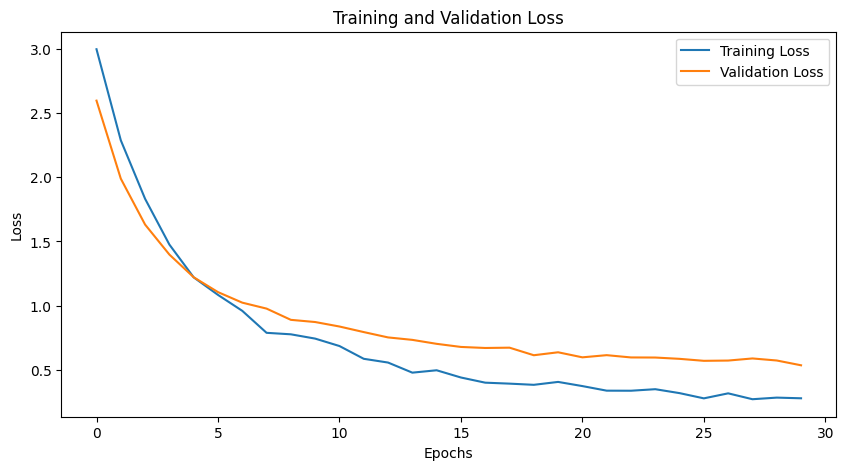

In [6]:
# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [31]:
global index
index = 0

#define the folders
folder_train = 'test'
out_folder = 'test_data'
# Create destination folders if they don't exist
os.makedirs(out_folder, exist_ok=True)

#detect all of the coins in the folder_train and save them in out_folder
for filename in os.listdir(folder_train):
    if filename.endswith(".JPG"): 
        img_path = os.path.join(folder_train, filename)
        img = cv.imread(img_path)
        background_type = classify_background(img)
        detected_coins = coin_detector(img,background_type,out_folder)

/var/folders/mw/n69_r9q11kz9n12zrf2hxtm80000gn/T/ipykernel_23593/3972254863.py:36: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned_holes = remove_small_holes(pre_processed_img, area_threshold=2500)


In [32]:
# Load the saved model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 23)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('model28_05.pth'))
model.eval()

# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = datasets.ImageFolder('labeled_test', transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names (make sure these match your training data)
class_names = ['10chfC', '10chfC_B', '10eurC', '1chf', '1chf_B', '1eur', '1eurC', 
               '20chfC', '20chfC_B', '20eurC', '2chf', '2chf_B', '2eur', '2eurC', 
               '50chfC', '50chfC_B', '50eurC', '5chf', '5chfC', '5chfC_B', '5chf_B', 
               '5eurC', 'outliers']


# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Perform inference and collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = correct / total
print(f'Accuracy of the model on the test dataset: {accuracy * 100:.2f}%')

Accuracy of the model on the test dataset: 83.79%


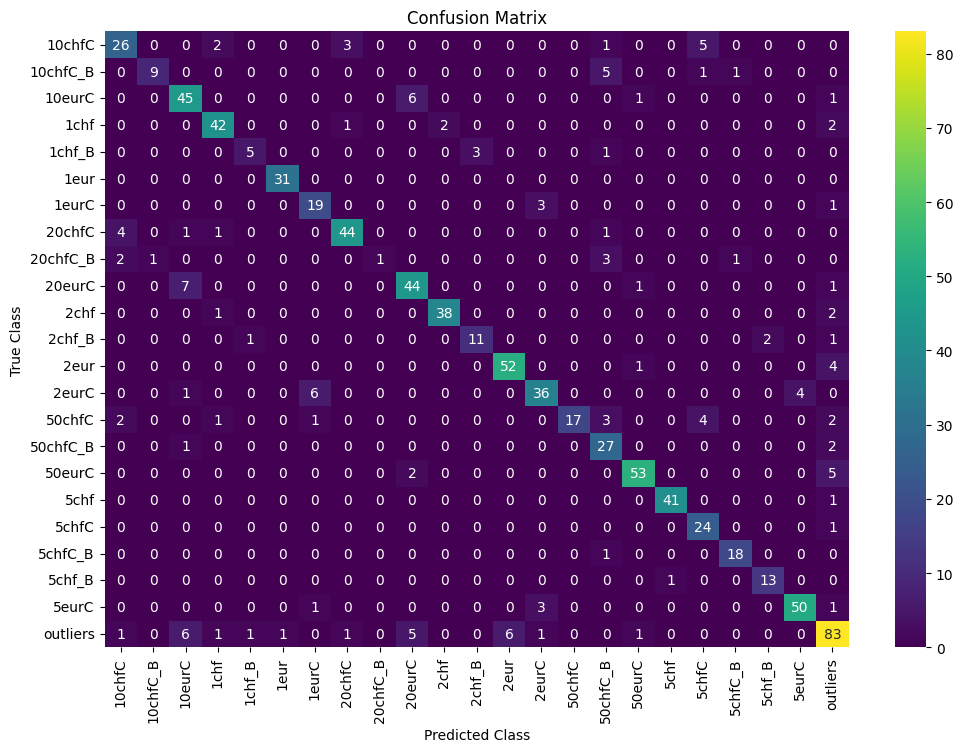

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [34]:
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self.outputs = []

        def hook(module, input, output):
            self.outputs.append(output)

        # Register hooks to specified layers
        for layer in layers:
            self.model._modules[layer].register_forward_hook(hook)

    def forward(self, x):
        self.outputs = []  # Clear previous outputs
        _ = self.model(x)
        return self.outputs


Features from conv1: torch.Size([64, 64, 4, 4])
Features from layer1: torch.Size([64, 256, 2, 2])
Features from layer2: torch.Size([64, 512, 1, 1])
Features from layer3: torch.Size([64, 1024, 1, 1])
Features from layer4: torch.Size([64, 2048, 1, 1])
Features from avgpool: torch.Size([64, 2048, 1, 1])


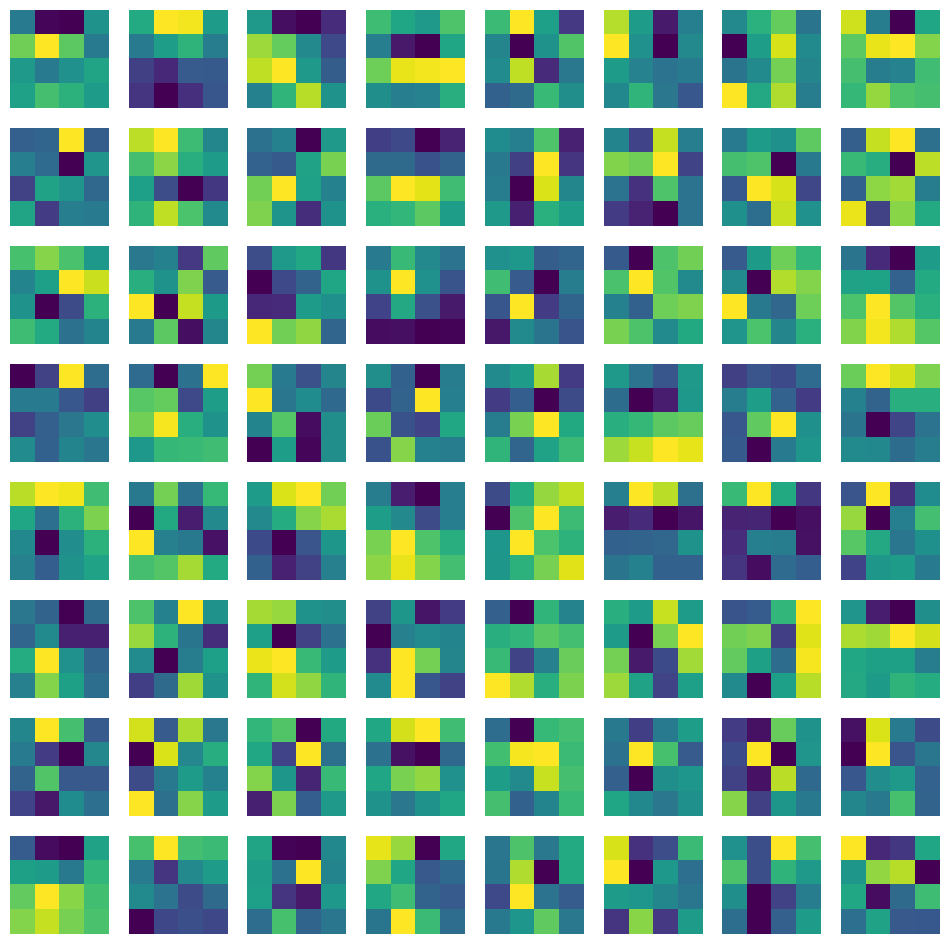

In [36]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the saved model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 23)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('model28_05.pth'))
model.eval()


# Define the layers you want to extract features from
layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

# Define a feature extractor class
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self.outputs = []

        def hook(module, input, output):
            self.outputs.append(output)

        # Register hooks to specified layers
        for layer in layers:
            if layer in self.model._modules:
                self.model._modules[layer].register_forward_hook(hook)
            else:
                # Handle the case for nested modules
                for name, module in self.model.named_modules():
                    if name == layer:
                        module.register_forward_hook(hook)

    def forward(self, x):
        self.outputs = []  # Clear previous outputs
        _ = self.model(x)
        return self.outputs

# Instantiate the feature extractor
feature_extractor = FeatureExtractor(model, layers_to_extract)

# Example input (this should be your actual data)
input_data = torch.randn(64, 3, 7, 7).to(device)  # Modify according to your input shape

# Extract features
features = feature_extractor(input_data)

# Print the extracted features
for i, feature in enumerate(features):
    print(f"Features from {layers_to_extract[i]}: {feature.shape}")

# Function to visualize feature maps from convolutional layers
def visualize_feature_map(feature_map):
    num_features = feature_map.shape[1]  # Number of feature maps
    size = feature_map.shape[2]  # Width and height of feature map
    rows = int(num_features ** 0.5)
    cols = num_features // rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i in range(rows):
        for j in range(cols):
            if i * cols + j < num_features:
                axes[i, j].imshow(feature_map[0, i * cols + j].cpu().detach().numpy(), cmap='viridis')
                axes[i, j].axis('off')
    plt.show()

# Visualize the first set of features
visualize_feature_map(features[0])

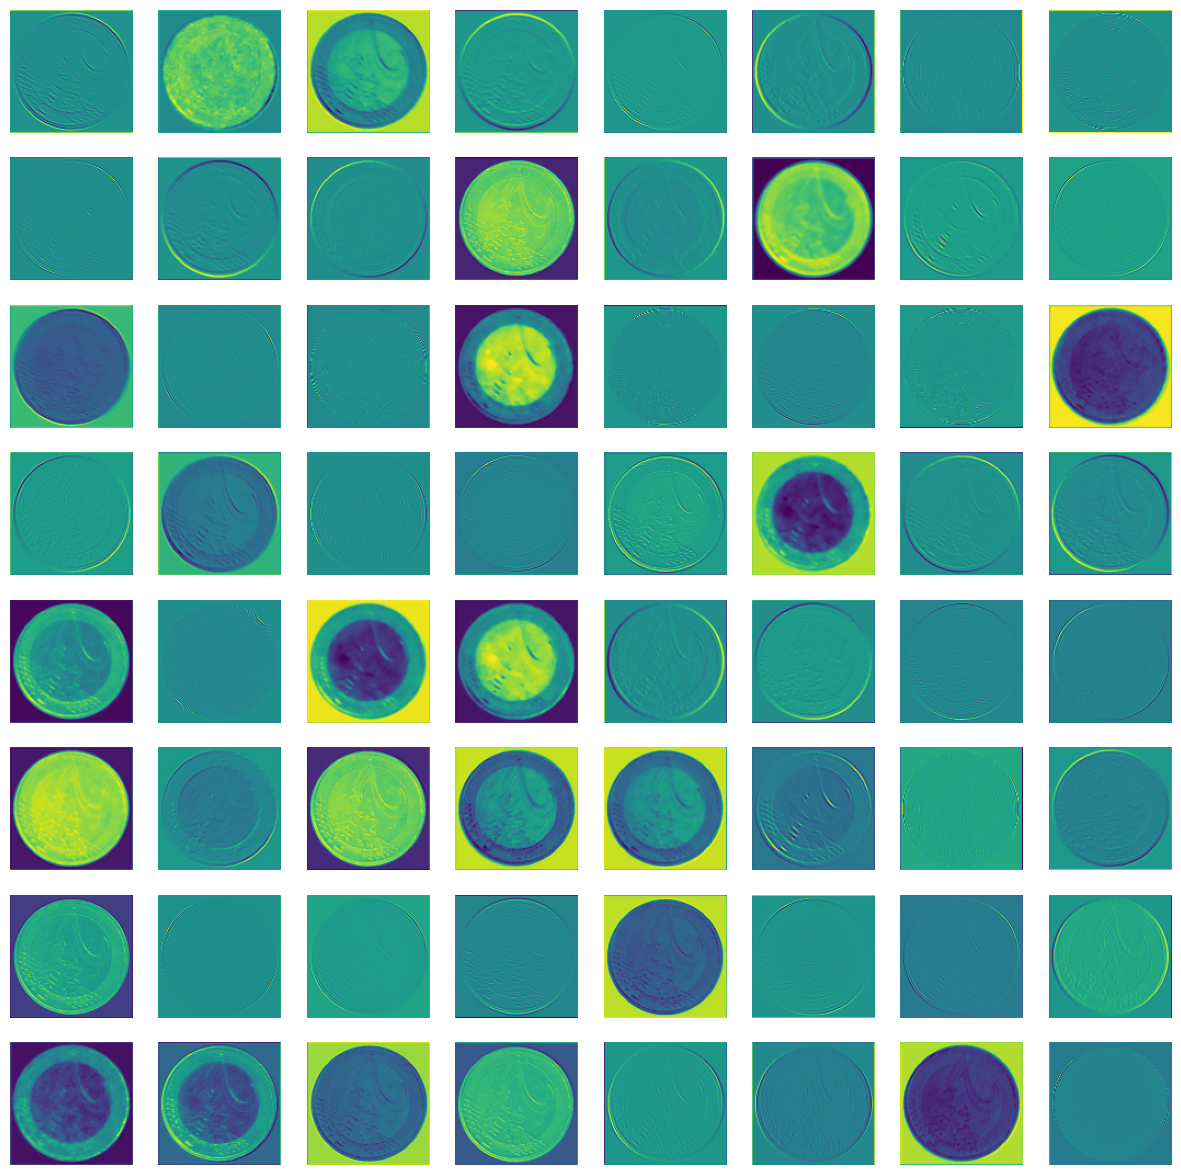

In [41]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

image_path = 'labeled_test/2eur/coin_22.jpg'
image = preprocess_image(image_path)

# Extract features from the first conv layer
model.eval()
with torch.no_grad():
    features = model.conv1(image)

# Convert features to numpy array for visualization
features = features.cpu().numpy()

# Visualize the features
def visualize_feature_map(feature_map):
    # Assuming feature_map is of shape [1, C, H, W]
    n_features = feature_map.shape[1]
    size = feature_map.shape[2]
    # Create a grid to display all the feature maps
    grid_size = int(np.ceil(np.sqrt(n_features)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            ax.axis('off')
            if i * grid_size + j < n_features:
                ax.imshow(feature_map[0, i * grid_size + j], cmap='viridis')
    plt.show()

visualize_feature_map(features)

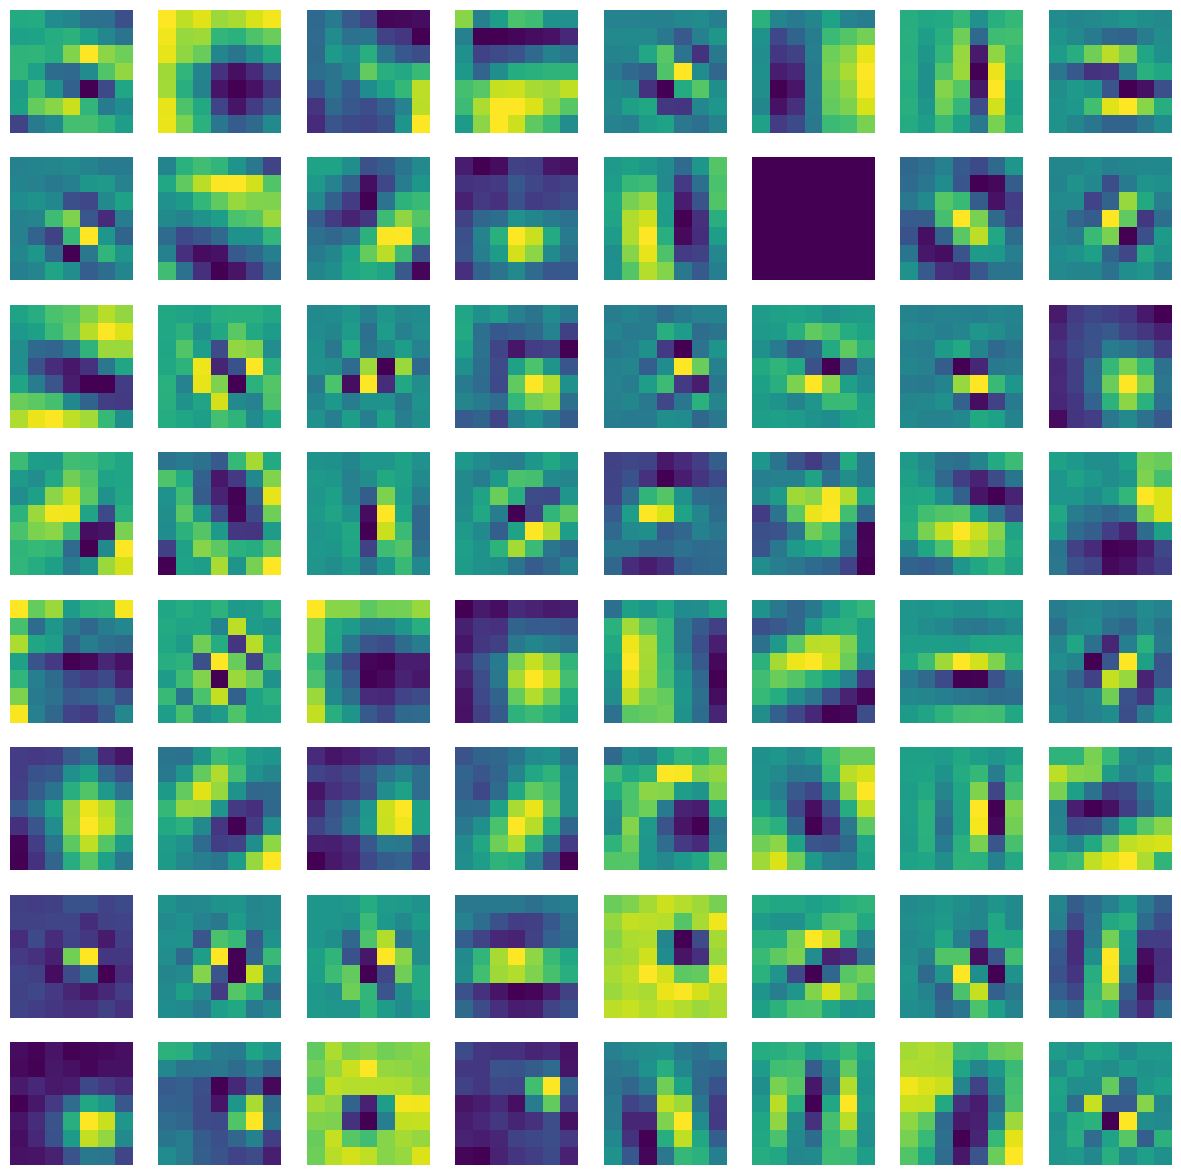

In [42]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = (filters - filters.min()) / (filters.max() - filters.min())  # Normalize for visualization
    n_filters = filters.shape[0]
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            ax.axis('off')
            if i * grid_size + j < n_filters:
                filter = filters[i * grid_size + j, 0, :, :]  # Assuming single channel filters
                ax.imshow(filter, cmap='viridis')
    plt.show()

# Example usage:
visualize_filters(model.conv1)

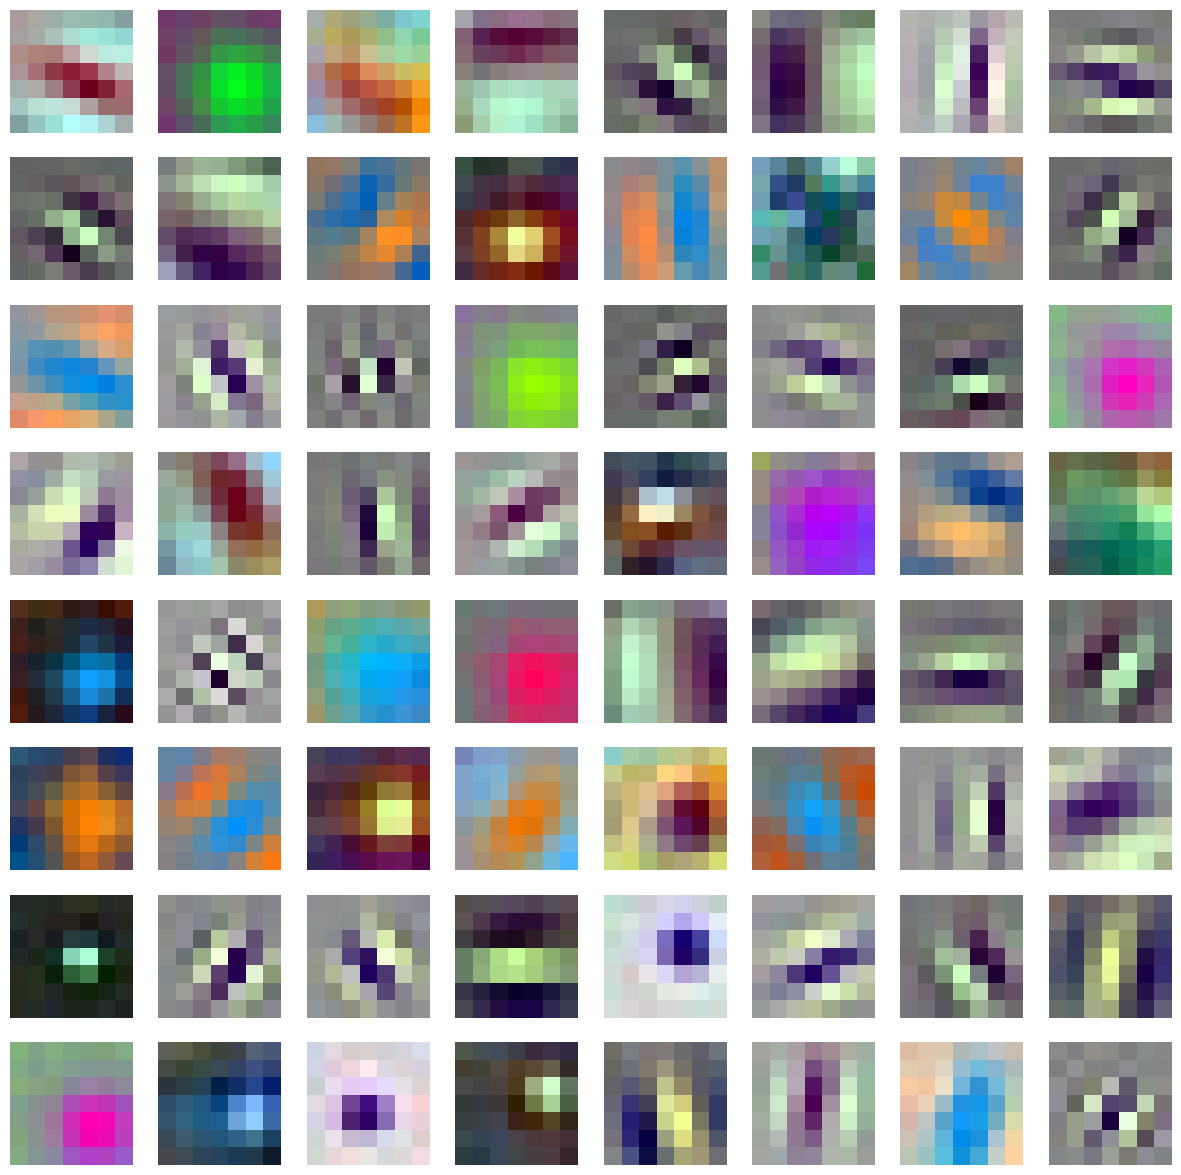

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming model is your ResNet model
def get_conv1_weights(model):
    # Accessing the weights of the first convolutional layer
    weights = model.conv1.weight.data.cpu().numpy()
    return weights

conv1_weights = get_conv1_weights(model)

def visualize_filter_weights(weights):
    # Assuming weights are of shape [out_channels, in_channels, height, width]
    n_filters = weights.shape[0]
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            ax.axis('off')
            filter_index = i * grid_size + j
            if filter_index < n_filters:
                # Normalize the weights to [0, 1] for visualization
                filter_weights = weights[filter_index]
                filter_weights -= filter_weights.min()
                filter_weights /= filter_weights.max()
                # For RGB filters, we need to transpose to (height, width, in_channels)
                if filter_weights.shape[0] == 3:  # Check if the filter is for RGB channels
                    filter_weights = np.transpose(filter_weights, (1, 2, 0))
                ax.imshow(filter_weights)
    plt.show()

visualize_filter_weights(conv1_weights)

### Saving the model for future use

In [32]:
torch.save(model.state_dict(), 'model28_05.pth')

# **Predicting the test images**

Once the model is trained, we can perform the predictions on the test images provided. In order to do this, we need to re-load the trained model, get the single coin images from each image, process them and then predict them:

In [13]:
# Re-load the model and explicit the processing function
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 23) 
model.load_state_dict(torch.load('model28_05.pth'))
model.eval()

# Define the transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
def predict_single_coin(image):
    # Convert NumPy array to PIL Image
    image_pil = Image.fromarray(image)

    #preprocess the image
    input_tensor = preprocess(image_pil)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    #predict
    with torch.no_grad():
        output = model(input_batch)
        _, predicted_class = torch.max(output, 1)
    
    return predicted_class.item()

Once the images are predicted, we will need to add them to a dictionnary which will keep track of how many coins are prenset in each image

In [15]:
#Explicit the class names used for prediction
class_names = ['10chfC', '10chfC_B', '10eurC', '1chf', '1chf_B', '1eur', '1eurC', 
               '20chfC', '20chfC_B', '20eurC', '2chf', '2chf_B', '2eur', '2eurC', 
               '50chfC', '50chfC_B', '50eurC', '5chf', '5chfC', '5chfC_B', '5chf_B', 
               '5eurC', 'outliers']

#Add the coin value to the dictionnary:
def add_to_dict(prediction, dictionnary):
    if class_names[prediction] == '10chfC' or class_names[prediction] == '10chfC_B' :
        dictionnary['0.1CHF'] += 1
    elif class_names[prediction] == '10eurC' :
        dictionnary['0.1EUR'] += 1
    elif class_names[prediction] == '1chf' or class_names[prediction]  == '1chf_B' :
        dictionnary['1CHF'] += 1
    elif class_names[prediction] == '1eur' :
        dictionnary['1EUR'] += 1
    elif class_names[prediction] == '1eurC' :
        dictionnary['0.01EUR'] += 1
    elif class_names[prediction] == '20chfC' or class_names[prediction] == '20chfC_B' :
        dictionnary['0.2CHF'] += 1
    elif class_names[prediction] == '20eurC' :
        dictionnary['0.2EUR'] += 1
    elif class_names[prediction] == '2chf' or class_names[prediction] == '2chf_B':
        dictionnary['2CHF'] += 1
    elif class_names[prediction] == '2eur' :
        dictionnary['2EUR'] += 1
    elif class_names[prediction] == '2eurC' :
        dictionnary['0.02EUR'] += 1
    elif class_names[prediction] == '50chfC' or class_names[prediction] == '50chfC_B':
        dictionnary['0.5CHF'] += 1
    elif class_names[prediction] == '50eurC' :
        dictionnary['0.5EUR'] += 1
    elif class_names[prediction] == '5chf' or class_names[prediction] == '5chf_B':
        dictionnary['5CHF'] += 1
    elif class_names[prediction] == '5chfC' or class_names[prediction] == '5chfC_B':
        dictionnary['0.05CHF'] += 1
    elif class_names[prediction] == '5eurC' :
        dictionnary['0.05EUR'] += 1
    elif class_names[prediction] == 'outliers':
        dictionnary['OOD'] += 1

    return dictionnary


In [16]:
#Create the dictionnary cointaining all of the coins in each image of the test set and predict the images
dict_list = []
folder = 'test'
for filename in os.listdir(folder):
    if filename.lower().endswith('.jpg'):
        img = cv.imread(os.path.join(folder, filename))

        #extract all of the coins from that test image in array
        background_type = classify_background(img)
        coins_array = coin_detector(img,background_type)

        #create the dictionary
        coins_dict = {
            'id' : filename[:-4],
            '5CHF' : 0,
            '2CHF': 0,
            '1CHF': 0,
            '0.5CHF': 0,
            '0.2CHF': 0,
            '0.1CHF': 0,
            '0.05CHF': 0,
            '2EUR': 0,
            '1EUR': 0,
            '0.5EUR': 0,
            '0.2EUR': 0,
            '0.1EUR': 0,
            '0.05EUR': 0,
            '0.02EUR': 0,
            '0.01EUR': 0,
            'OOD': 0
            }
        
        #predict the image class and add it to the dictionary
        for coin_image in coins_array:
            predicted_class = predict_single_coin(coin_image)
            coins_dict = add_to_dict(predicted_class, coins_dict)
        dict_list.append(coins_dict)

/var/folders/mw/n69_r9q11kz9n12zrf2hxtm80000gn/T/ipykernel_57873/3972254863.py:36: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned_holes = remove_small_holes(pre_processed_img, area_threshold=2500)
[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


In [17]:
#Sort the dictionnary and save it as a csv file for submission
fieldnames = ['id', '5CHF','2CHF','1CHF','0.5CHF','0.2CHF','0.1CHF','0.05CHF','2EUR','1EUR','0.5EUR','0.2EUR',
    '0.1EUR','0.05EUR','0.02EUR','0.01EUR','OOD']

#sort the dictionnary based on the last 3 digits of the fieldname --> we want ascending order
def extract_last_three_as_int(filename):
    return int(filename[-3:])
dict_list.sort(key=lambda x: extract_last_three_as_int(x['id']))

#extract csv file
def write_csv(file_path, data, fieldnames):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)
write_csv('predicted_coins28_05.csv', dict_list, fieldnames=fieldnames)